# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
import utils as ut

In [2]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

# Useful functions 
def gaussianKernel(sigma):
    N = np.int(np.ceil(3*sigma))
    x = y = np.linspace(np.int(-3*sigma),np.int(3*sigma),2*N+1)
    X,Y = np.meshgrid(x,y)
    noyau = np.exp(-(X*X+Y*Y)/(2*sigma*sigma))
    return noyau/noyau.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [3]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ix, Iy, Ig = ut.returnSobelDirv(image)
    a = convolve2d(Ix**2,gaussianKernel(scale),mode='same')
    b = convolve2d(Iy**2,gaussianKernel(scale),mode='same')
    c = convolve2d(Ix * Iy,gaussianKernel(scale),mode='same')
    M = np.asarray([[a,c],[c,b]])
    det = a*b - c*c
    trace = a + b 
    return det - kappa * trace **2

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

    comme sigma = (W-1)/6 , pour W = 15 , sigma = 2.3

<Figure size 432x288 with 0 Axes>

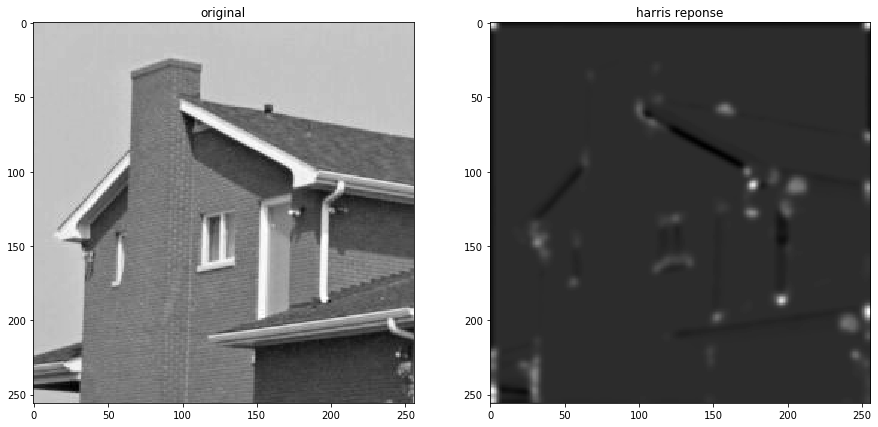

In [4]:
house2 = np.array(Image.open('img/house2.png'))
ut.niceDisplay14_bis([house2,computeR(house2,2.3,0.04)],["original","harris reponse"])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Your answer...

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [5]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>thres,1,0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [9]:
def rnms(R,Rbin):
    """ Array[n, m],Array[n, m] -> Array[n, m] 
    """
    
    out = np.zeros(R.shape)
    for x in range(1,out.shape[0]-1):
        for y in range(1,out.shape[1]-1):
            if Rbin[x][y] == 1 and (np.amax(R[x-1:x+2, y-1:y+2]) == R[x][y]):
                out[x][y] = 1
    return out

In [7]:
def rnms_roll(R,Rbin):
    """ Array[n, m],Array[n, m] -> Array[n, m] 
    """
    bottom = np.roll(R,1,axis=0)
    left = np.roll(R,-1,axis=0)
    top = np.roll(R,1,axis=1)
    right = np.roll(R,-1,axis=1)
        
    cond = (R > bottom) & (R > left) & (R > top) & (R > right) & (Rbin == 1)
    
    return np.where(cond==True,1,0)

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [10]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """

    R = computeR(image,sigma,kappa)
    Rbin = thresholdR(R,thres)
    return rnms(R,Rbin)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

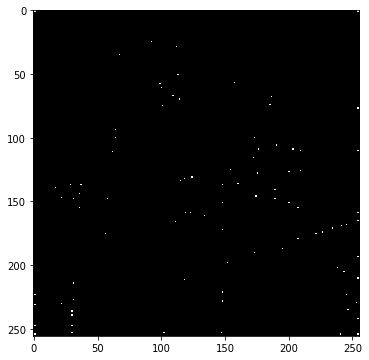

In [20]:
c = cornerDetector(house2,2,0.04,10e6)
ut.imshow(c)

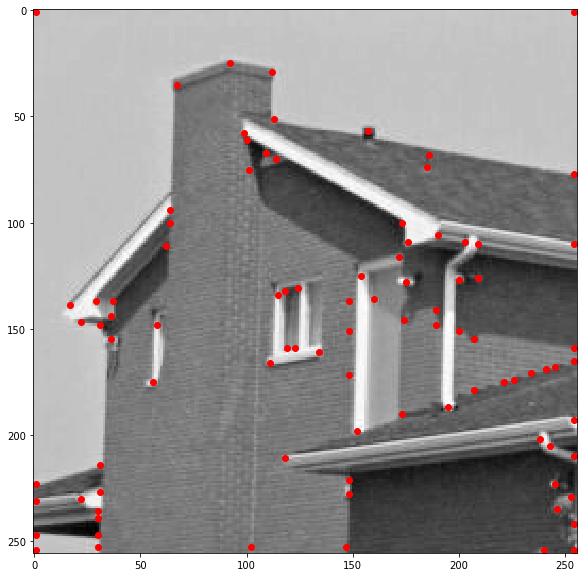

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(house2, cmap="gray")
plt.scatter(np.nonzero(c)[1],np.nonzero(c)[0], color="red",marker="o")
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

    evaluation en fonction de sigma :

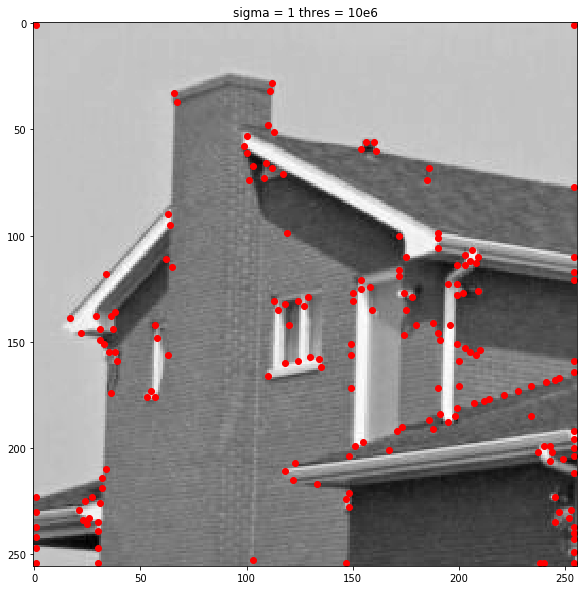

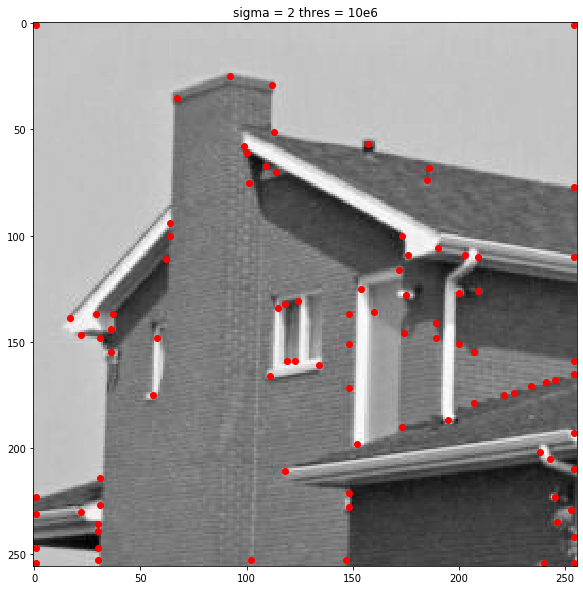

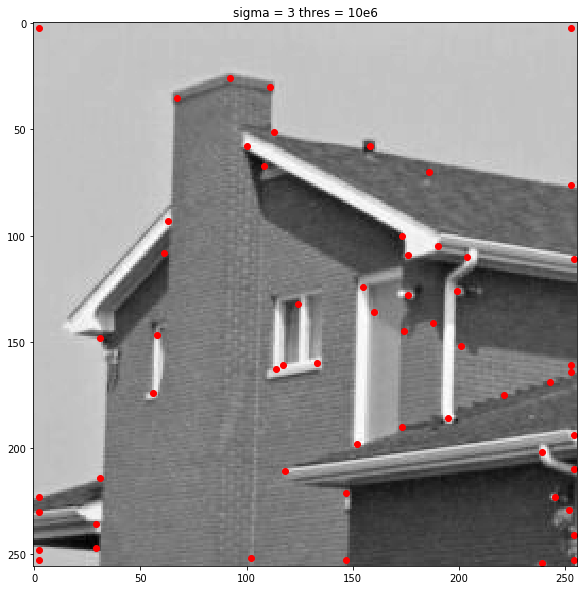

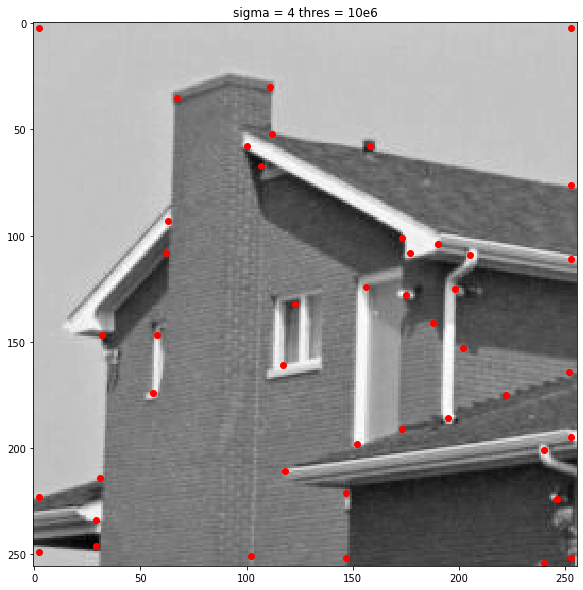

In [13]:
for s in range(1,5):
    c = cornerDetector(house2,s,0.04,10e6)
    plt.figure(figsize=(10,10))
    plt.imshow(house2, cmap="gray")
    plt.scatter(np.nonzero(c)[1],np.nonzero(c)[0], color="red",marker="o")
    plt.title("sigma = {} thres = 10e6".format(s))
    plt.show()

    evaluation en fonction de threshold :

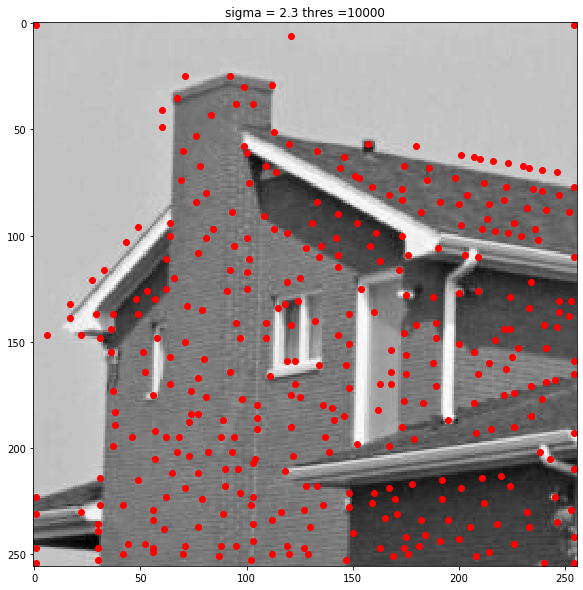

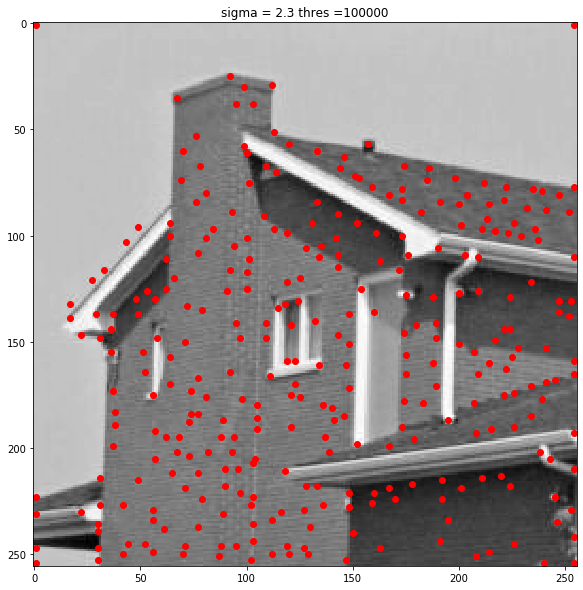

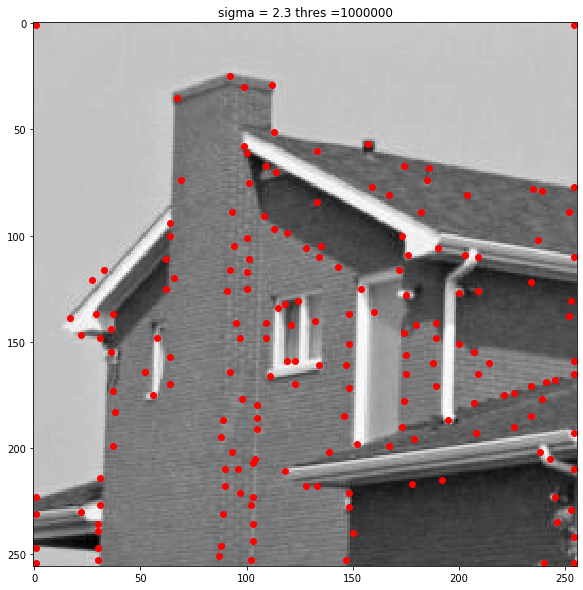

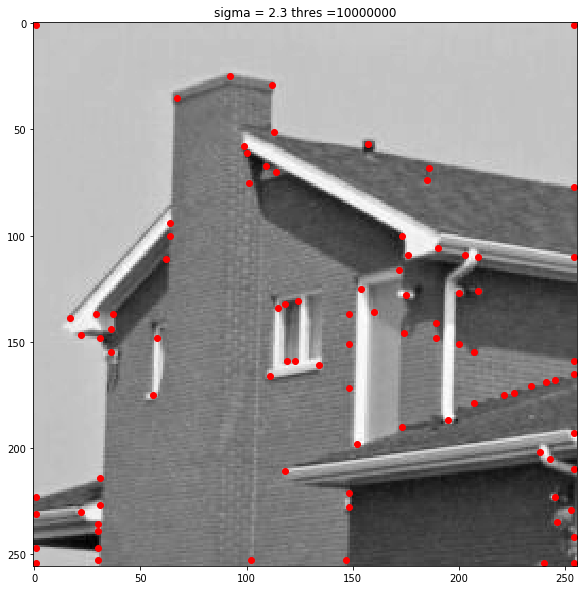

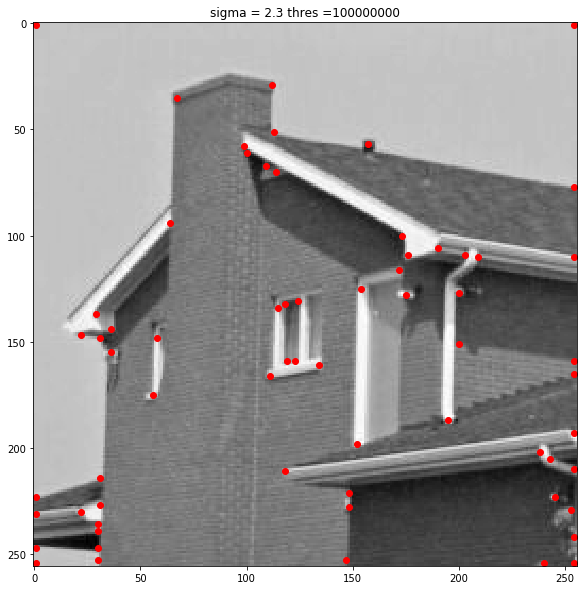

In [22]:
for s in range(4,9):
    c = cornerDetector(house2,2,0.04,10 ** s)
    plt.figure(figsize=(10,10))
    plt.imshow(house2, cmap="gray")
    plt.scatter(np.nonzero(c)[1],np.nonzero(c)[0], color="red",marker="o")
    plt.title("sigma = 2.3 thres ={}".format(10 ** s))
    plt.show()

    des bonnes valeurs de sigma et threshold sont (2,10e6) pour cette image

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

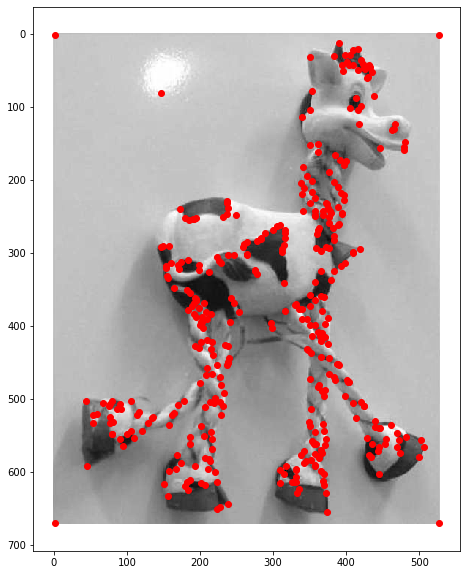

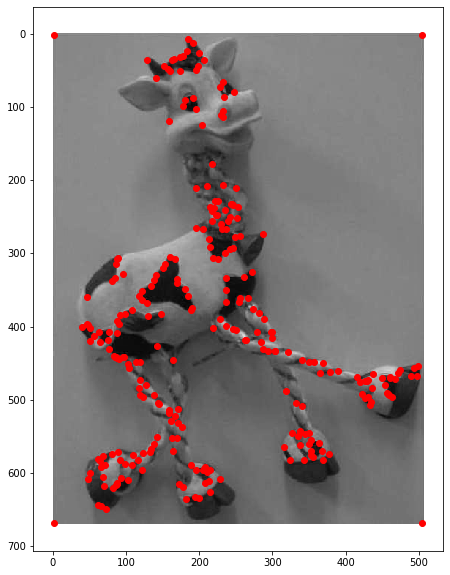

In [54]:
toyHorse1 = np.array(Image.open('img/toyHorse1.png'))
toyHorse2 = np.array(Image.open('img/toyHorse2.png'))

c1 = cornerDetector(toyHorse1,2,0.04,10e6)
c2 = cornerDetector(toyHorse2,2,0.04,10e6)

plt.figure(figsize=(10,10))
plt.imshow(toyHorse1, cmap="gray")
plt.scatter(np.nonzero(c1)[1],np.nonzero(c1)[0], color="red",marker="o")
plt.show()


plt.figure(figsize=(10,10))
plt.imshow(toyHorse2, cmap="gray")
plt.scatter(np.nonzero(c2)[1],np.nonzero(c2)[0], color="red",marker="o")
plt.show()

2) What are the dynamic ranges of these two images ?

In [55]:
print("dynamic range toyHorse1 :", toyHorse1.max()-toyHorse1.min())
print("dynamic range toyHorse2 :", toyHorse2.max()-toyHorse2.min())

dynamic range toyHorse1 : 254
dynamic range toyHorse2 : 253


3) What are the transformations beetween the two images ?

    les transfprmations sont: la rotation, le point de vue et l'eclairage.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

    pour l'image ci-dessus on ne peut pas dire que la detection est invariante par rotation ou pas car on a plusieurs transformation entre les deux images, par contre on sait que Harris est invariant par rotation mais pas pour brightness. ( exemple ci-dessus).

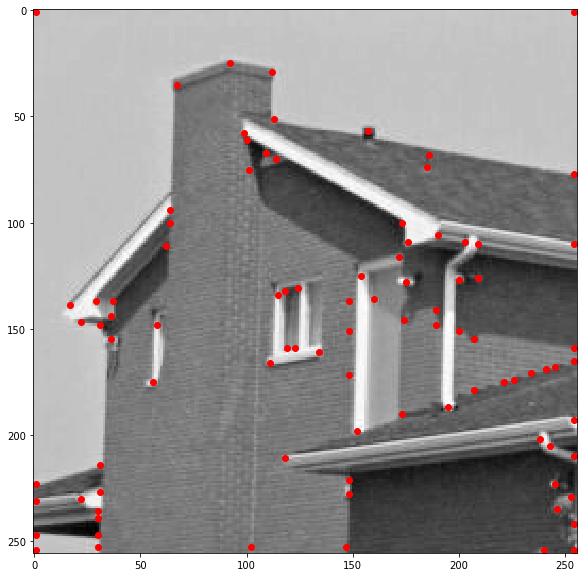

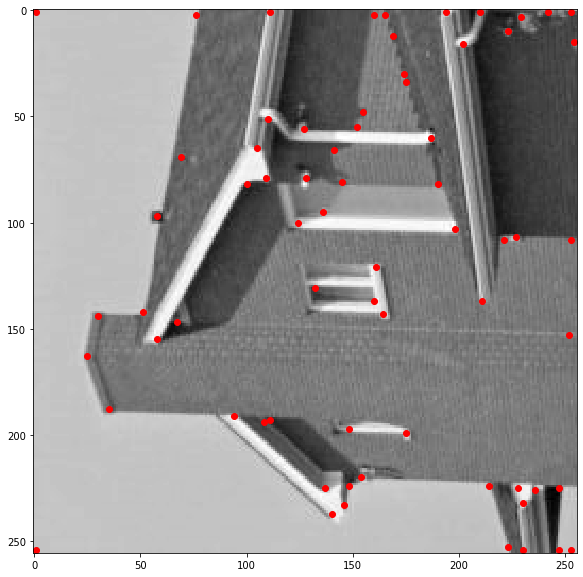

In [23]:
c = cornerDetector(house2,2,0.04,10e6)
plt.figure(figsize=(10,10))
plt.imshow(house2, cmap="gray")
plt.scatter(np.nonzero(c)[1],np.nonzero(c)[0], color="red",marker="o")
plt.show()


house2_rot = ut.rotateImage(house2,90)
c = cornerDetector(house2_rot,2.3,0.04,10e6)
plt.figure(figsize=(10,10))
plt.imshow(house2_rot, cmap="gray")
plt.scatter(np.nonzero(c)[1],np.nonzero(c)[0], color="red",marker="o")
plt.show()

